## Este notebook apresenta a exploração dos dados após do pre-processamento do dataset que irá alimentar a rede neural Keras

In [1]:
import pandas as pd
import re
import gensim
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance

In [2]:
#setting parameters for data visualization
np.set_printoptions(threshold=None, precision=2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('precision', 2)

### Opening movie reviews

In [3]:
messages = pd.read_csv('./chatdata/movie_lines_pre_processed_keras.tsv', header = None, delimiter="\t", quoting=3, encoding='ISO-8859-2')

In [4]:
messages.columns = ['msg_line', 'user_id', 'movie_id', 'msg', 'msg_2', 'msg_pre_processed', 'target']

In [5]:
messages.head(10)

,msg_line,user_id,movie_id,msg,msg_2,msg_pre_processed,target
0,L49,u0,m0,Did you change your hair?,did you change your hair,No.,1
1,L50,u3,m0,No.,no,You might wanna think about it,0
2,L51,u0,m0,You might wanna think about it,you might wanna think about it,I need to think more about it,0
3,L59,u9,m0,I missed you.,i missed you,It says here you exposed yourself to a group o...,0
4,L60,u8,m0,It says here you exposed yourself to a group o...,it say here you exposed yourself to a group of...,It was a bratwurst. I was eating lunch.,0
5,L61,u9,m0,It was a bratwurst. I was eating lunch.,it wa a bratwurst i wa eating lunch,With the teeth of your zipper?,0
6,L62,u8,m0,With the teeth of your zipper?,with the teeth of your zipper,can you explain it better?,1
7,L63,u7,m0,You the new guy?,you the new guy,So they tell me...,1
8,L64,u2,m0,So they tell me...,so they tell me,C'mon. I'm supposed to give you the tour.,0
9,L65,u7,m0,C'mon. I'm supposed to give you the tour.,cmon im supposed to give you the tour,I need to think more about it,0


### Print profile

In [6]:
from pandas_profiling import ProfileReport

In [7]:
profile = ProfileReport(messages, title="Pandas Profiling Report")

In [8]:
profile

### Data exploration

In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   msg_line           304713 non-null  object
 1   user_id            304713 non-null  object
 2   movie_id           304713 non-null  object
 3   msg                304713 non-null  object
 4   msg_2              304704 non-null  object
 5   msg_pre_processed  304713 non-null  object
 6   target             304713 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 16.3+ MB


In [10]:
messages.describe()

,target
count,304713.00
mean,0.31
std,0.46
min,0.00
25%,0.00
50%,0.00
75%,1.00
max,1.00


#### Data Analysis based on this article
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools?utm_source=medium&utm_medium=crosspost&utm_campaign=blog-exploratory-data-analysis-natural-language-processing-tools

In [11]:
data = messages['msg_pre_processed']

### Number of characters of each message

<AxesSubplot:>

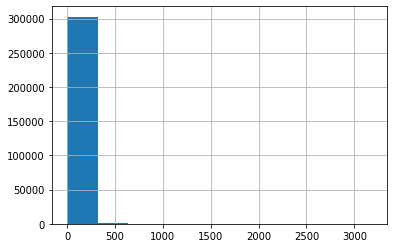

In [12]:
#histogram to display the number of character of each message
data.str.len().hist()

The number of characters are between 0 and 500

## Value types

In [13]:
#checking the average word length
data_set = [type(item) for item in data]
data_set = set(data_set)
data_set

{str}

## Print float values

In [14]:
float_val = [it for it in data if isinstance(it, float)]
print(len(float_val))
float_val = set(float_val)
print(float_val)

0
set()


In [15]:
messages[messages['msg_pre_processed'].isna()]

,msg_line,user_id,movie_id,msg,msg_2,msg_pre_processed,target


### Removing non-alphabetical messages

In [16]:
#example of sequence of null messages
#messages[538:540]

In [17]:
#filling the nan messages with a string
messages = messages.fillna('UNKNOWN')
data = messages['msg']

### Number of words for each message

<AxesSubplot:>

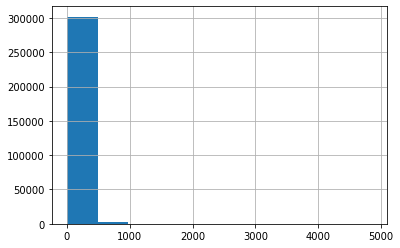

In [18]:
#number of words for each message
data.str.split(' ').\
    map(lambda x: len(str(x))).\
    hist()

The number of words are between 0 and 100

### Average word length

<AxesSubplot:>

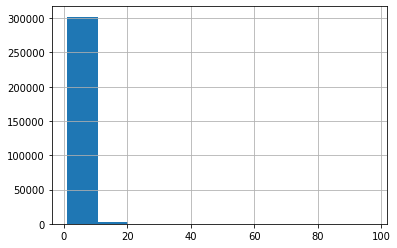

In [19]:
#checking the average word length
data.str.split(' ').\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

The length of words goes from 0 to 15

### Distribuition of stopwords in the mesages

In [20]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/douglas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
#checkig the distribuition of stopwrds in the mesages
stop=set(stopwords.words('english'))
corpus=[]
msg_ = data.str.split()
msg_ = msg_.values.tolist()
corpus=[word for i in msg_ for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

In [22]:
len(list(dic.values()))

164

In [23]:
import matplotlib.pyplot as plt

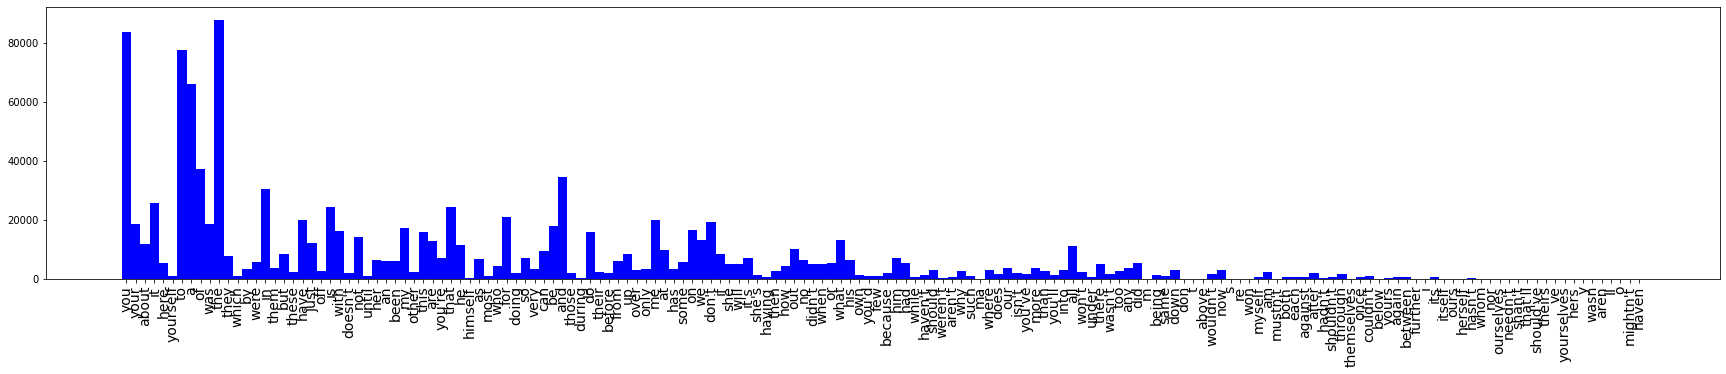

In [24]:
x = dic.keys()
y = dic.values()
plt.subplots(figsize=(30,5))
plt.bar(x, y, 1, color='b')
plt.xticks(list(x), rotation=90, fontsize=14)
plt.show()

The majority of stop words are 'to', 'you', 'the' and 'a'

### Occurences of each word

In [25]:
from collections import Counter
import seaborn as sns

<AxesSubplot:>

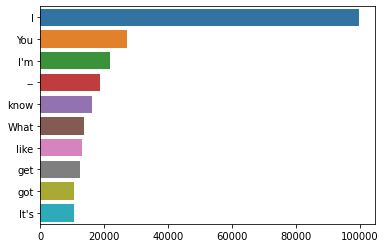

In [26]:
#ploting the occurences of each word
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

The word 'I' has the biggest occurrence. There are a lot of messages like dashes that can be removed

### Get the most frequent n-grams

In [27]:
from nltk.util import ngrams

In [28]:
#get the most frequent n-grams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [29]:
def plot_n_gram(corpus, n=2):
    top_n_bigrams=get_top_ngram(corpus,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

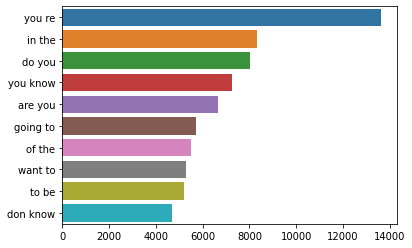

In [30]:
plot_n_gram(data, 2)

The more frequent bigram is 'you re'

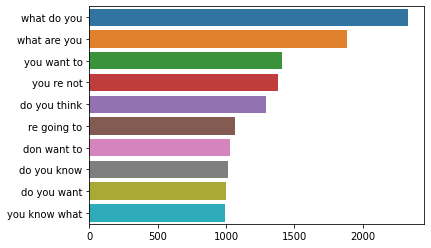

In [31]:
plot_n_gram(data, 3)

There are a lot of short questions like 'what do you...?', 'what are you...?', and answers like 'you want to...'

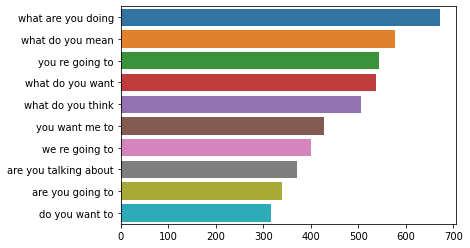

In [32]:
plot_n_gram(data, 4)

There are a lot of repeated questions and answers or part of them

### Sentimental analysis

In [33]:
from textblob import TextBlob

In [34]:
#checkig the polarity of the messages
def polarity(text):
    return TextBlob(text).sentiment.polarity

<AxesSubplot:>

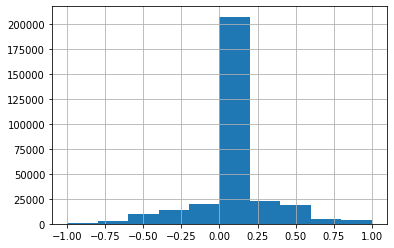

In [35]:
messages['polarity_score']=data.\
   apply(lambda x : polarity(x))
messages['polarity_score'].hist()

The majority of polarity is neutral

### Named entity recognition

- TYPE	DESCRIPTION
- PERSON	People, including fictional.
- NORP	Nationalities or religious or political groups.
- FAC	Buildings, airports, highways, bridges, etc.
- ORG	Companies, agencies, institutions, etc.
- GPE	Countries, cities, states.
- LOC	Non-GPE locations, mountain ranges, bodies of water.
- PRODUCT	Objects, vehicles, foods, etc. (Not services.)
- EVENT	Named hurricanes, battles, wars, sports events, etc.
- WORK_OF_ART	Titles of books, songs, etc.
- LAW	Named documents made into laws.
- LANGUAGE	Any named language.
- DATE	Absolute or relative dates or periods.
- TIME	Times smaller than a day.
- PERCENT	Percentage, including ”%“.
- MONEY	Monetary values, including unit.
- QUANTITY	Measurements, as of weight or distance.
- ORDINAL	“first”, “second”, etc.
- CARDINAL	Numerals that do not fall under another type.

In [36]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [37]:
#transform the messages in a big document
def get_entities(corpus, int_limit=0, end_limit=100):
    msg_all = ' '.join(data[int_limit:end_limit])
    doc = nlp(msg_all)

    entity_list = [(x.text,x.label_) for x in doc.ents]
    
    return entity_list

In [38]:
%%time

ent_list = set()
skip = 1000
i = 0
lim = len(data)
#lim = 20000

while(i < lim):    
    ent_list = set(get_entities(data, i, i+skip))
    ent_list.union(ent_list)
    i = i + skip
    print('Processed '+str(i)+' of '+str(lim)+' messages')

Processed 1000 of 304713 messages
Processed 2000 of 304713 messages
Processed 3000 of 304713 messages
Processed 4000 of 304713 messages
Processed 5000 of 304713 messages
Processed 6000 of 304713 messages
Processed 7000 of 304713 messages
Processed 8000 of 304713 messages
Processed 9000 of 304713 messages
Processed 10000 of 304713 messages
Processed 11000 of 304713 messages
Processed 12000 of 304713 messages
Processed 13000 of 304713 messages
Processed 14000 of 304713 messages
Processed 15000 of 304713 messages
Processed 16000 of 304713 messages
Processed 17000 of 304713 messages
Processed 18000 of 304713 messages
Processed 19000 of 304713 messages
Processed 20000 of 304713 messages
Processed 21000 of 304713 messages
Processed 22000 of 304713 messages
Processed 23000 of 304713 messages
Processed 24000 of 304713 messages
Processed 25000 of 304713 messages
Processed 26000 of 304713 messages
Processed 27000 of 304713 messages
Processed 28000 of 304713 messages
Processed 29000 of 304713 mes

Processed 232000 of 304713 messages
Processed 233000 of 304713 messages
Processed 234000 of 304713 messages
Processed 235000 of 304713 messages
Processed 236000 of 304713 messages
Processed 237000 of 304713 messages
Processed 238000 of 304713 messages
Processed 239000 of 304713 messages
Processed 240000 of 304713 messages
Processed 241000 of 304713 messages
Processed 242000 of 304713 messages
Processed 243000 of 304713 messages
Processed 244000 of 304713 messages
Processed 245000 of 304713 messages
Processed 246000 of 304713 messages
Processed 247000 of 304713 messages
Processed 248000 of 304713 messages
Processed 249000 of 304713 messages
Processed 250000 of 304713 messages
Processed 251000 of 304713 messages
Processed 252000 of 304713 messages
Processed 253000 of 304713 messages
Processed 254000 of 304713 messages
Processed 255000 of 304713 messages
Processed 256000 of 304713 messages
Processed 257000 of 304713 messages
Processed 258000 of 304713 messages
Processed 259000 of 304713 m

In [39]:
len(ent_list)

191

In [40]:
ent_list

{('" My Lord', 'WORK_OF_ART'),
 ('"Excuse me My Lord.', 'WORK_OF_ART'),
 ('"The Standard"', 'WORK_OF_ART'),
 ("'Bus and Truck'", 'WORK_OF_ART'),
 ("'The Con-ti-nen-tal'", 'WORK_OF_ART'),
 ('1', 'CARDINAL'),
 ('2', 'CARDINAL'),
 ('40', 'CARDINAL'),
 ('45', 'CARDINAL'),
 ('5', 'CARDINAL'),
 ('55', 'CARDINAL'),
 ('90 minutes', 'TIME'),
 ('A week', 'DATE'),
 ('ADC', 'ORG'),
 ('Ahab', 'PERSON'),
 ('Anders', 'PERSON'),
 ('Another fifteen seconds', 'TIME'),
 ('Apfelstrudel', 'WORK_OF_ART'),
 ('Aye', 'PERSON'),
 ('Aye-gor', 'PERSON'),
 ('Ayegor', 'GPE'),
 ('Ayegor', 'ORG'),
 ('Basutos', 'PERSON'),
 ('Beaufort Frankenstein', 'PERSON'),
 ('Beijing', 'GPE'),
 ('Bombardier', 'PERSON'),
 ('Boy', 'PERSON'),
 ('Bugler', 'PERSON'),
 ('CHELMSFORD', 'PERSON'),
 ('Cairo', 'GPE'),
 ('Carlson', 'ORG'),
 ('Cavalry', 'PERSON'),
 ('Cetshwayo', 'ORG'),
 ('Chelmsford', 'PERSON'),
 ('Christians', 'NORP'),
 ('Come on Xander', 'WORK_OF_ART'),
 ('Command', 'ORG'),
 ('Crealock', 'ORG'),
 ('Crealock', 'PERSON'),
 ('D

There are some personal names, real locals, name of organizations and work of art that can be removed or replaced for generic terms. 

In [41]:
ent_df = pd.DataFrame(list(ent_list))

In [42]:
ent_df

,0,1
0,Nice,PERSON
1,"""Excuse me My Lord.",WORK_OF_ART
2,second,ORDINAL
3,Fron,ORG
4,fifth,ORDINAL
5,Sikali Horse My Lord,PERSON
6,tonight,TIME
7,one,CARDINAL
8,The Con-ti-nen-tal,WORK_OF_ART
9,ADC,ORG


### Entity frequency

In [43]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

In [44]:
%%time
#count the number of each entity
ent=data.\
    apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

CPU times: user 55min 55s, sys: 12.8 s, total: 56min 8s
Wall time: 56min 42s


<AxesSubplot:>

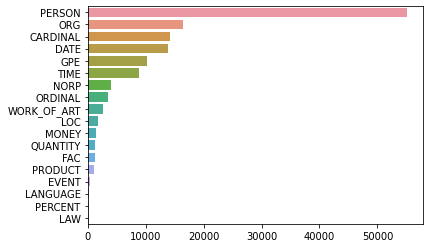

In [45]:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

### Most comon tokens per entity

In [46]:
def ner(text,ent="PERSON"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

In [ ]:
%%time
#count the tokens for a given entity type
gpe=data.apply(lambda x: ner(x, 'PERSON'))
gpe=[i for x in gpe for i in x]
counter=Counter(gpe)

In [ ]:
x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

## Parts of Speach Tagging

There are eight main parts of speech:

- Noun (NN)- Joseph, London, table, cat, teacher, pen, city
- Verb (VB)- read, speak, run, eat, play, live, walk, have, like, are, is
- Adjective(JJ)- beautiful, happy, sad, young, fun, three
- Adverb(RB)- slowly, quietly, very, always, never, too, well, tomorrow
- Preposition (IN)- at, on, in, from, with, near, between, about, under
- Conjunction (CC)- and, or, but, because, so, yet, unless, since, if
- Pronoun(PRP)- I, you, we, they, he, she, it, me, us, them, him, her, this
- Interjection (INT)- Ouch! Wow! Great! Help! Oh! Hey! Hi!

In [ ]:
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize

In [ ]:
def remove_duplicated_spaces(corpus):
    #remove duplicated spaces
    corpus_alt = re.sub(r' +', ' ', corpus)

    return corpus_alt

In [ ]:
msg_no_space = [remove_duplicated_spaces(str(m)) for m in data]
msg_no_space = pd.Series(msg_no_space)

In [ ]:
def pos(text):
    #matched = re.match(r" +", text)
    if text != ' ':
        #print(text)
        pos=nltk.pos_tag(word_tokenize(text))
        #print(pos)
        pos=list(map(list,zip(*pos)))[1]
        return pos
    return

In [ ]:
%%time
tags=msg_no_space[0:5000].apply(lambda x : pos(x))
#tags = [pos(m) for m in msg_no_space[0:10000]]
#tags
tags=[x for l in tags for x in l]
counter=Counter(tags)

In [ ]:
x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

In [ ]:
### most commonly nouns
def get_adjs(text, _tag='PRP'):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag == _tag:
            adj.append(word)
    return adj

In [ ]:
%%time
words=data.apply(lambda x : get_adjs(x))
words=[x for l in words for x in l]
counter=Counter(words)

In [ ]:
x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

## Text complexy

Flesch Reading Ease (FRE)
<br>Higher scores indicate material that is easier to read, lower numbers mark harder-to-read passages:
- 0-30 College
- 50-60 High school
- 60+ Fourth grade

In [ ]:
from textstat import flesch_reading_ease

In [ ]:
%%time
reading = data.\
   apply(lambda x : flesch_reading_ease(x))
reading.hist()

The text is easy to read

In [ ]:
x=[i for i in range(len(reading)) if reading[i]<0]

messages.iloc[x]['msg_pre_processed'].head()